In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import matplotlib.pyplot as plt
%matplotlib inline

tf.executing_eagerly()

True

### Setting up the problem
A football match is taking place a big city. Both teams set up tents where fans can visit to grab some drinks and have fun with other supporters. FYI, Madrid is chosen for this example just because I live there right now.

In [2]:
def contour_normal_values(dist_object, mesh_points, samples=None):
    if samples is None:
        samples = dist_object.sample(1000)
    lb_patch = tf.reduce_min(samples, axis=0) - tf.linalg.diag_part(dist_object.covariance())*2
    ub_patch = tf.reduce_max(samples, axis=0) + tf.linalg.diag_part(dist_object.covariance())*2
    Xv = tf.linspace(lb_patch[0], ub_patch[0], mesh_points)
    Yv = tf.linspace(lb_patch[1], ub_patch[1], mesh_points)
    Xvm, Yvm = tf.meshgrid(Xv, Yv) # square mesh
    Xv = tf.reshape(Xvm, (-1,1))
    Yv = tf.reshape(Yvm, (-1,1))
    # Compute the pdf for every point of the mesh
    Zprob = dist_object.prob(tf.concat([Xv, Yv],axis=1))
    Zprob = tf.reshape(Zprob, (mesh_points, mesh_points))
    Zmask = tf.where(Zprob < 0.0005, float("NaN"), 1)
    return Xvm, Yvm, Zmask

def plot_fans(model1=None, model2=None):
    madrid = plt.imread("madrid_map.png")
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(madrid, extent=[-5, 20, -5, 20]);
    g1x ,g1y = [G1_samples.numpy()[:,i] for i in [0,1]]
    ax.scatter(g1x, g1y, c='b')
    g2x ,g2y = [G2_samples.numpy()[:,i] for i in [0,1]]
    ax.scatter(g2x, g2y, c='r');
    if model1 is not None:
        x1c, y1c, z1c = contour_normal_values(model1, 100)
        ax.contourf(x1c, y1c, z1c, cmap=plt.cm.bone, alpha=0.2)
    if model2 is not None:
        x2c, y2c, z2c = contour_normal_values(model2, 100)
        ax.contourf(x2c, y2c, z2c, cmap=plt.cm.bone, alpha=0.2)
    plt.xlim(-5, 20)
    plt.ylim(-5, 20)

It is assumed supporters gather around the tents but we have no idea about true location of the tents. What it can be known is fans' location, according to the GPS of their phones. For demostration purposes, the data has been generated with Tensorflow, and they are normally distributed.

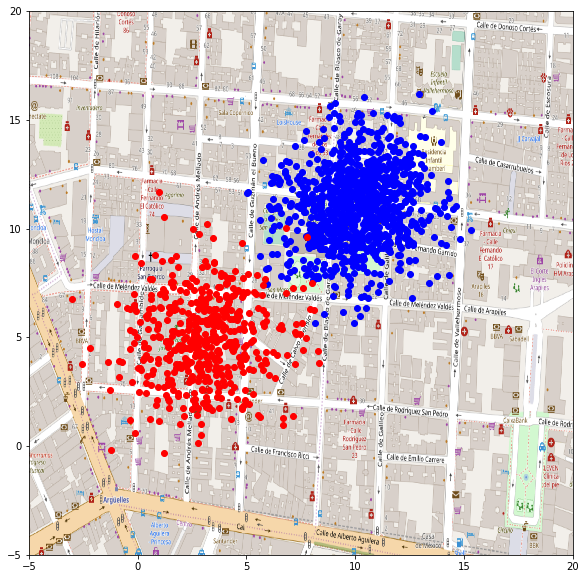

In [3]:
# Group 1
G1_mean = tf.constant([10., 11.]); G1_cov = tf.constant([[3.,0.4],[0.4,3.]])
G1_dist = tfd.MultivariateNormalFullCovariance(loc = G1_mean, covariance_matrix = G1_cov)
G1_samples = G1_dist.sample(1000)
# Group 2
G2_mean = tf.constant([3.,5.]); G2_cov = tf.constant([[3.8,0.2],[0.2,3.8]])
G2_dist = tfd.MultivariateNormalFullCovariance(loc = G2_mean, covariance_matrix = G2_cov)
G2_samples = G2_dist.sample(500)

total_fans = tf.concat([G1_samples, G2_samples], axis=0)
plot_fans()

## Gaussian Mixture Model (GMM) from scratch

A custom class is built in order to easily update the parameters of the model by assignment. At the moment of writing, Tensorflow Probability does not let you edit the parameter `covariance_matrix` by assignment.

In [4]:
class MVNormal(object):
    def __init__(self, mu_value, sigma_value):
        self.__mu = mu_value
        self.__sigma = sigma_value
        self.model = tfd.MultivariateNormalFullCovariance(loc = self.__mu, covariance_matrix=self.__sigma)
        
    def __get_mu(self):
        return self.__mu
    
    def __set_mu(self, mu):
        self.__mu = mu
        self.update_model()
        
    def __get_sigma(self):
        return self.__sigma
    
    def __set_sigma(self, sigma):
        self.__sigma = sigma
        self.update_model()
        
    def update_model(self):
        self.model = tfd.MultivariateNormalFullCovariance(loc = self.__mu, covariance_matrix=self.__sigma)
        
    mu = property(__get_mu, __set_mu)
    sigma = property(__get_sigma, __set_sigma)    

Here, it is defined the class to run the EM algorithm for GMM. Just a brief reminder:
* the E-step predicts the team each fan supports
* the M-step updates the parameters of the model, the mean (the location of the tents) the covariance matrix (the space that occupied by the fans) and the proportion of fans of each team

In [5]:
class EMmodel(object):
    def __init__(self, data, mu_s, sigma_s):
        self.iter = 0
        self.data = data
        self.mu = mu_s # A list
        self.sigma = sigma_s # A list
        self.proportions = tf.Variable([0.5, 0.5])
        self.responsibilities = tf.ones_like(self.data)/self.data.shape[1]
        self.model_obs = [MVNormal(self.mu[0], self.sigma[0]), MVNormal(self.mu[1], self.sigma[1])]
        
    def update_mu(self, k):
        r_cluster = self.responsibilities[:,k]
        return tf.reduce_sum(self.data*tf.broadcast_to(r_cluster[:,tf.newaxis],[len(self.data),2]),axis=0)/sum(r_cluster)
        
    def update_sigma(self, k):
        r_cluster = self.responsibilities[:,k]
        centered_data = self.data-self.model_obs[k].mu
        sigma_unbounded = tf.reduce_sum(tf.einsum('ki,kj->kij',centered_data,centered_data)*r_cluster[:,tf.newaxis,tf.newaxis], axis=0)
        return sigma_unbounded/(self.proportions[k]*len(self.data))
    
    def E_step(self):
        new_responsibilities = tf.Variable(tf.zeros_like(self.responsibilities))
        for i, (p_k, m_k) in enumerate(zip(self.proportions.numpy(), self.model_obs)):
            new_responsibilities[:,i].assign(p_k*m_k.model.prob(self.data))
        self.responsibilities = new_responsibilities
        self.responsibilities = self.responsibilities/tf.broadcast_to(tf.reduce_sum(new_responsibilities, axis=1, keepdims=True),[*self.responsibilities.shape])
        
    def M_step(self):
        # Update proportions
        p = tf.reduce_mean(tf.cast(self.responsibilities >= 0.5, tf.float32), axis=0)
        self.proportions.assign(p)
        # Update means
        self.model_obs[0].mu = self.update_mu(0)
        self.model_obs[1].mu = self.update_mu(1)
        # Update sigma
        self.model_obs[0].sigma = self.update_sigma(0)
        self.model_obs[1].sigma = self.update_sigma(1)
        
    def print_params(self):
        format_array = lambda x: str(np.ma.round(x.numpy(), 3)).replace('\n','')
        print('{:<3d}{:<15s}{:<15s}{:<33s}{:<15s}{:<33s}'.format(
            self.iter,
            format_array(self.proportions),
            format_array(self.model_obs[0].mu), 
            format_array(self.model_obs[0].sigma),
            format_array(self.model_obs[1].mu), 
            format_array(self.model_obs[1].sigma)))
        self.iter+=1

### Case 1: Shifted distributions
We are going to test the algorithm with two examples. The first one the prior knowledge of the Gaussian makes that the initial distribution is a little bit far from the location of the groups.

In [25]:
# Parameters to estimate (prior knowledge)
estimate_mu1 = tf.Variable([15.,11.])
estimate_sigma1 = tf.Variable([[2.,0.],[0.,2.]], dtype=tf.float32)
estimate_mu2 = tf.Variable([0.,-1.])
estimate_sigma2 = tf.Variable([[1.2,0.],[0.,1.2]], dtype=tf.float32)
mymodel=EMmodel(total_fans, [estimate_mu1, estimate_mu2], [estimate_sigma1, estimate_sigma2])

Despite the uncertainty of tents' location, **we can make a guess from the people's location going to those tents**. Let's say that given the current image we are blindfolded and ask us to make a guess about the location of the tents.

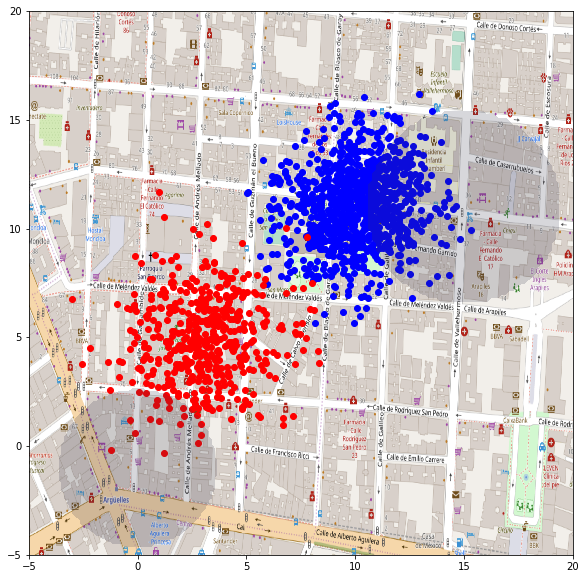

In [26]:
plot_fans(*[g.model for g in mymodel.model_obs])

Now, the model is ready to run the E-step and M-step iteratively. After few iterations, the algorithm will eventually converge. If the degree of overlapping between both groups is significant it may take some time to stabilize.

The parameters are monitored for every round.

In [27]:
print('{:^3s}{:^15s}{:^15s}{:^33s}{:^15s}{:^33s}'.format('i','prop C1-C2','mean C1', 'covariance matrix C1', 'mean C2', 'covariance matrix C2'))
for i in range(10):
    mymodel.E_step()
    mymodel.M_step()
    mymodel.print_params()

 i   prop C1-C2       mean C1          covariance matrix C1           mean C2          covariance matrix C2       
0  [0.713 0.287]  [ 9.754 10.777][[4.255 1.323] [1.323 3.937]]    [2.692 4.607]  [[ 2.591 -0.289] [-0.289  2.948]]
1  [0.687 0.313]  [ 9.92  10.889][[3.462 0.864] [0.864 3.599]]    [2.838 4.807]  [[ 2.821 -0.079] [-0.079  3.392]]
2  [0.676 0.324]  [10.005 10.96 ][[3.07  0.573] [0.573 3.326]]    [2.93 4.89]    [[3.032 0.047] [0.047 3.554]]    
3  [0.671 0.329]  [10.036 10.993][[2.954 0.46 ] [0.46  3.191]]    [2.985 4.924]  [[3.196 0.132] [0.132 3.613]]    
4  [0.671 0.329]  [10.049 11.008][[2.91  0.416] [0.416 3.129]]    [3.012 4.94 ]  [[3.301 0.182] [0.182 3.659]]    
5  [0.669 0.331]  [10.054 11.014][[2.898 0.398] [0.398 3.11 ]]    [3.025 4.948]  [[3.337 0.209] [0.209 3.666]]    
6  [0.668 0.332]  [10.057 11.017][[2.893 0.391] [0.391 3.102]]    [3.031 4.952]  [[3.354 0.221] [0.221 3.671]]    
7  [0.668 0.332]  [10.058 11.018][[2.889 0.388] [0.388 3.097]]    [3.033 4.953] 

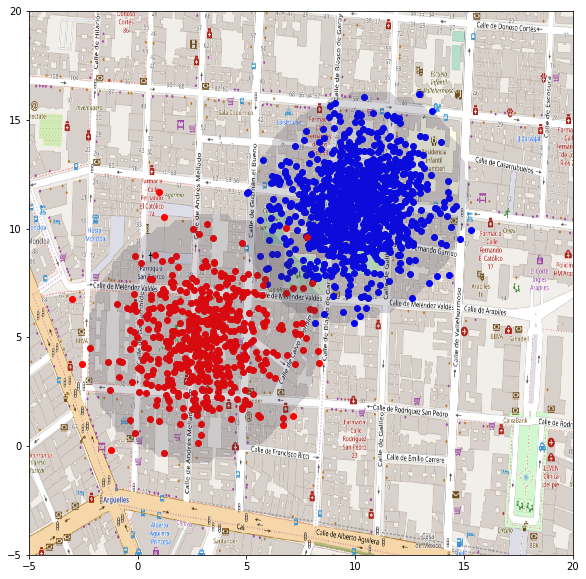

In [28]:
plot_fans(*[g.model for g in mymodel.model_obs])

In 10 rounds the model has been able to fit both groups.

### Case 2: Overlapping distributions
This example just runs the EM algorithm by setting the initial distribution in such a way that exists some **overlap between the two Gaussians** at the beginning. Take a look below these lines.

In [21]:
# Parameters to estimate (prior knowledge)
estimate_mu1 = tf.Variable([15.,11.])
estimate_sigma1 = tf.Variable([[5.,0.],[0.,5.]], dtype=tf.float32)
estimate_mu2 = tf.Variable([5.,8.])
estimate_sigma2 = tf.Variable([[5,0.],[0.,6]], dtype=tf.float32)
mymodel=EMmodel(total_fans, [estimate_mu1, estimate_mu2], [estimate_sigma1, estimate_sigma2])

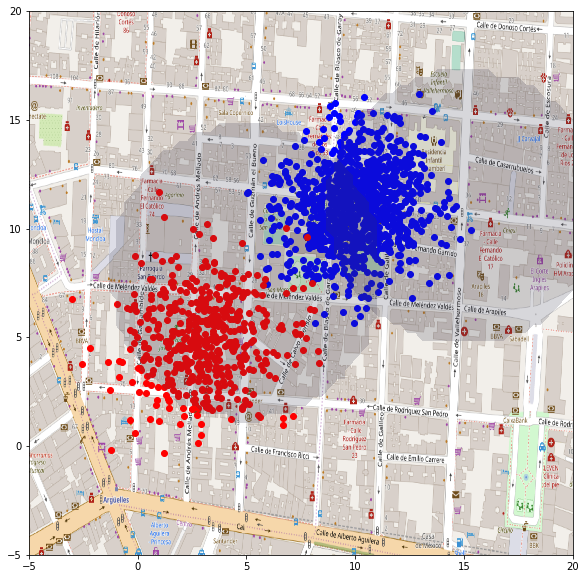

In [22]:
plot_fans(*[g.model for g in mymodel.model_obs])

In [23]:
print('{:^3s}{:^15s}{:^15s}{:^33s}{:^15s}{:^33s}'.format('i','prop C1-C2','mean C1', 'covariance matrix C1', 'mean C2', 'covariance matrix C2'))
for i in range(30):
    mymodel.E_step()
    mymodel.M_step()
    mymodel.print_params()

 i   prop C1-C2       mean C1          covariance matrix C1           mean C2          covariance matrix C2       
0  [0.404 0.596]  [11.027 11.432][[ 1.538 -0.182] [-0.182  2.772]][5.558 7.41 ]  [[10.424  7.708] [ 7.708 10.834]]
1  [0.478 0.522]  [10.751 11.292][[ 1.578 -0.122] [-0.122  2.337]][5.473 7.302]  [[12.305  8.985] [ 8.985 12.329]]
2  [0.53 0.47]    [10.562 11.227][[ 1.664 -0.054] [-0.054  2.179]][5.229 7.048]  [[12.826  9.068] [ 9.068 12.645]]
3  [0.564 0.436]  [10.443 11.198][[1.79  0.009] [0.009 2.177]]    [4.969 6.779]  [[12.592  8.555] [ 8.555 12.239]]
4  [0.591 0.409]  [10.374 11.19 ][[1.913 0.054] [0.054 2.233]]    [4.721 6.525]  [[11.999  7.795] [ 7.795 11.521]]
5  [0.603 0.397]  [10.332 11.189][[2.059 0.085] [0.085 2.354]]    [4.48  6.284]  [[10.802  6.647] [ 6.647 10.279]]
6  [0.616 0.384]  [10.305 11.191][[2.183 0.103] [0.103 2.468]]    [4.243 6.052]  [[9.538 5.48 ] [5.48  9.041]]    
7  [0.625 0.375]  [10.278 11.185][[2.305 0.12 ] [0.12  2.583]]    [4.005 5.825] 

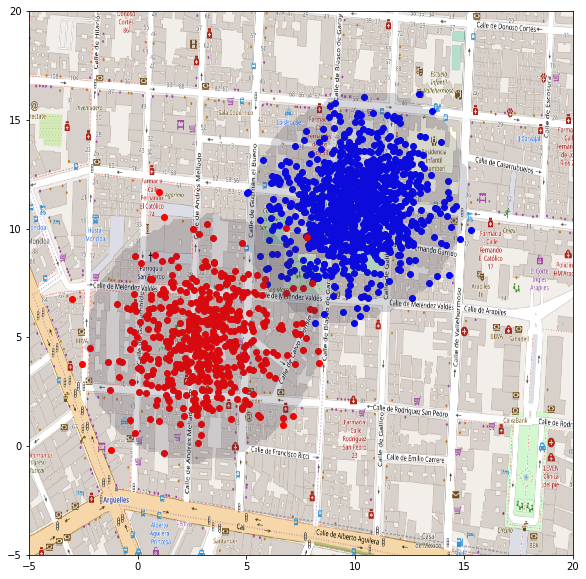

In [24]:
plot_fans(*[g.model for g in mymodel.model_obs])

When the distributions are overlapping it may be necessary to execute more rounds. In this case, 30 rounds are more than enough. as you can see the parameters for both cases are very similar.
## References
https://thelongrun.blog/2020/03/04/expectation-maximization-algorithm-for-the-masses/